# Automatic Classification of Sharepoint Documents based on their Titles

University of Bern / CAS Applied data Science Projet Module 3 / Alfonso Garcia-Miguel and Lionel Perret

# 1. Overview of the Project


**Overall Concept**

<img src="../Printscreen/Concept.jpg" alt="Drawing" style="width: 1000px;">

This project aims at automating the classification of documents based on the title. The possible classes correspond to four different departments of an organisation. Using supervised learning from a dataset containing more than 200.000 labelled documents, with title and department, we train the machine so that, given a textual input (the title of the document) we obtain the corresponding department that this document belongs to.
As it is common in machine learning projects, the first step involves some data cleaning (selecting the appropriate features of the dataset, removing special characters...). For this particular project, we decided to include the file extension as part of the title, since this information might affect the en d result.

# 2 Load the necessary packages and define the necessary functions

In [ ]:
import pandas as pd
import os

import collections
import pathlib
import re
import string

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras import utils
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import matplotlib.pyplot as plt

# Relevant imports for tf graph
%load_ext tensorboard

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from datetime import datetime
from packaging import version

from tensorflow import keras

In [ ]:
# Plot Function that takes a History object as input variable and the name of the metric to be plotted

def plot_graphs(history, metric):
  plt.plot(history.history[metric])              # history.history attribute is a record of training/validation- 
  plt.plot(history.history['val_'+metric], '')   # Loss values and metrics values at sucessive epochs
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

# 3. Pre-process the dataset

## 3. 1 Convert the dataset into a file structure that can be read by tf.keras.preprocessing

In [ ]:
# load the dataset for our M3 Project
df = pd.read_csv('CleanTitle.csv', usecols=[1,2,3], encoding='utf-8')
df

,Name,File_type,Service;;
0,200903 07 PfR21 HQ Budget Decelerate Inp...,ppt,FAD;;
1,FTE Control DP xls,xls,FAD;;
2,2020 09 03 ICRC Letter re IRS Correspondence w...,pdf,FAD;;
3,supporting organizations practice guide pdf,pdf,FAD;;
4,2019 06 19 PWS JEH FL Bar Tax intl charitable ...,pdf,FAD;;
...,...,...,...
185723,Test pg 0 pdf,pdf,PROT;;
185724,Full test negotiation pdf,pdf,PROT;;
185725,Gaza PCPiE LL Pres 24 11 2017 EGY ppt,ppt,PROT;;
185726,ECS PCP CoH EWPA+Ben ppt,ppt,PROT;;


In [ ]:
# Define the path of the directory where all the files will be stored
files_dir = './../../Title-Files'

In [ ]:
# Create the root directory
os.mkdir(files_dir)
# Create the sub-directories
os.mkdir(files_dir+'/FAD/')
os.mkdir(files_dir+'/REM/')
os.mkdir(files_dir+'/PROT/')
os.mkdir(files_dir+'/ASSIST/')

In [ ]:
# Create a df with the "FAD" category
df_FAD = df.loc[df['Service;;'].isin(['FAD;;'])]
df_FAD

,Name,File_type,Service;;
0,200903 07 PfR21 HQ Budget Decelerate Inp...,ppt,FAD;;
1,FTE Control DP xls,xls,FAD;;
2,2020 09 03 ICRC Letter re IRS Correspondence w...,pdf,FAD;;
3,supporting organizations practice guide pdf,pdf,FAD;;
4,2019 06 19 PWS JEH FL Bar Tax intl charitable ...,pdf,FAD;;
...,...,...,...
185702,cicr buletti andrea pdf,pdf,FAD;;
185703,ICRC Premises Projects Business Case ICRC E...,ppt,FAD;;
185704,Worksheet in ICRC Premises Projects Busines...,xls,FAD;;
185705,161216 HiB ERB FEA Notice pdf,pdf,FAD;;


In [ ]:
# Create separate title-files within the "FAD" sub-directory
i=0
for index, row in df_FAD.iterrows():
    if i > len(df_FAD):
       break
    else:
       f = open(files_dir + '/FAD/' + str(i) + '.txt', 'w', encoding='utf-8')
       f.write(row[0])
       f.close()
       i+=1

# Create separate title-files within the "REM" sub-directory
df_REM = df.loc[df['Service;;'].isin(['REM;;'])]
i=0
for index, row in df_REM.iterrows():
    if i > len(df_REM):
       break
    else:
       f = open(files_dir + '/REM/'+ str(i) + '.txt', 'w', encoding='utf-8')
       f.write(row[0])
       f.close()
       i+=1

# Create separate title-files within the "PROT" sub-directory
df_PROT = df.loc[df['Service;;'].isin(['PROT;;'])]
i=0
for index, row in df_PROT.iterrows():
    if i > len(df_PROT):
       break
    else:
       f = open(files_dir + '/PROT/'+ str(i) + '.txt', 'w', encoding='utf-8')
       f.write(row[0])
       f.close()
       i+=1

# Create separate title-files within the "ASSIST" sub-directory
df_ASSIST = df.loc[df['Service;;'].isin(['ASSIST;;'])]
i=0
for index, row in df_ASSIST.iterrows():
    if i > len(df_ASSIST):
       break
    else:
       f = open(files_dir + '/ASSIST/'+ str(i) + '.txt', 'w', encoding='utf-8')
       f.write(row[0])
       f.close()
       i+=1

## 3.2 Create the training and Validation data set
### 3.2.1 Considerations about data sets:
bka

In [ ]:
# Define the batch size and the seed
batch_size = 32
seed = 42

In [ ]:
# Training data set: "raw_train_ds" is a "tf.data.Dataset" object
raw_train_ds = preprocessing.text_dataset_from_directory(
    files_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

# Check which label correspond to which number
for i, label in enumerate(raw_train_ds.class_names):
  print("Label", i, "corresponds to", label)

Found 181566 files belonging to 4 classes.
Using 145253 files for training.
Label 0 corresponds to ASSIST
Label 1 corresponds to FAD
Label 2 corresponds to PROT
Label 3 corresponds to REM


In [ ]:
# Validation data set: "raw_val_ds" is a "tf.data.Dataset" object
raw_val_ds = preprocessing.text_dataset_from_directory(
    files_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 181566 files belonging to 4 classes.
Using 36313 files for validation.


In [ ]:
# Creation-import of test data set, no use?

#test_dir = dataset_dir/'test'
#raw_test_ds = preprocessing.text_dataset_from_directory(
#    test_dir, batch_size=batch_size)

# 4. Prepare the text data
"TextVectorization" : transforms a batch of strings into either a list of token indices (one sample = 1D tensor of integer token indices) or a dense representation (one sample = 1D tensor of float values representing data about the sample's tokens)
https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization

The processing of each sample contains the following steps:

- standardize each sample (usually lowercasing + punctuation stripping)
- split each sample into substrings (usually words)
- recombine substrings into tokens (usually ngrams)
- index tokens (associate a unique int value with each token)
- transform each sample using this index, either into a vector of ints or a dense float vector

In [ ]:
VOCAB_SIZE = 10000

binary_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='binary')

### output_mode: 

Optional specification for the output of the layer. Values can be "int", "binary", "count" or "tf-idf", configuring the layer as follows: "int": Outputs integer indices, one integer index per split string token. When output == "int", 0 is reserved for masked locations; this reduces the vocab size to max_tokens-2 instead of max_tokens-1 "binary": Outputs a single int array per batch, of either vocab_size or max_tokens size, containing 1s in all elements where the token mapped to that index exists at least once in the batch item. "count": As "binary", but the int array contains a count of the number of times the token at that index appeared in the batch item. "tf-idf": As "binary", but the TF-IDF algorithm is applied to find the value in each token slot.

### output_sequence_length:

Only valid in INT mode. If set, the output will have its time dimension padded or truncated to exactly output_sequence_length values, resulting in a tensor of shape [batch_size, output_sequence_length] regardless of how many tokens resulted from the splitting step. Defaults to None.

In [ ]:
MAX_SEQUENCE_LENGTH = 250

int_vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH)

### Turning strings into numerical values:

Using a text-only dataset (without the labels), we use the adapt function to build an index of strings to integers.

In [ ]:
# Make a text-only dataset (without labels)
# "adapt" is used to fit the state of the preprocessing layer to the dataset.
# This will cause the model to build an index of strings to integers.
train_text = raw_train_ds.map(lambda text, labels: text)
binary_vectorize_layer.adapt(train_text)
int_vectorize_layer.adapt(train_text)

Then, we use two modes:
- `Binary` returns an array denoting which tokens (words) exist at least once in the input. 
- `Int` replaces each token by an integer, respecting their order.

This can be seen with the `print` command below.

In [ ]:
def binary_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return binary_vectorize_layer(text), label

In [ ]:
def int_vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return int_vectorize_layer(text), label

In [ ]:
# Retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_title, first_label = text_batch[0], label_batch[0]
print("Document Title", first_title)
print("Label", first_label)

Document Title tf.Tensor(b'WHO Breastfeeding 2017 pdf', shape=(), dtype=string)
Label tf.Tensor(0, shape=(), dtype=int32)


In [ ]:
print("'binary' vectorized Document Title:", 
      binary_vectorize_text(first_title, first_label)[0])

'binary' vectorized Document Title: tf.Tensor([[1. 1. 0. ... 0. 0. 0.]], shape=(1, 10000), dtype=float32)


In [ ]:
print("'int' vectorized Document Title:",
      int_vectorize_text(first_title, first_label)[0])

'int' vectorized Document Title: tf.Tensor(
[[382   1  39   2   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [ ]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

### finalizing the preparation of the dataset
As the final step, we apply the `TextVectorization` function we defined above to the train and validation datasets:

In [ ]:
binary_train_ds = raw_train_ds.map(binary_vectorize_text)
binary_val_ds = raw_val_ds.map(binary_vectorize_text)
#binary_test_ds = raw_test_ds.map(binary_vectorize_text)

int_train_ds = raw_train_ds.map(int_vectorize_text)
int_val_ds = raw_val_ds.map(int_vectorize_text)
#int_test_ds = raw_test_ds.map(int_vectorize_text)

# 5. Train the model

## Taking care of performance:
Since the volume of our dataset is quite big, we use two methods to optimize the performance of the machine:
- `cache()` keeps data in memory after it is taken from the disk. This ensures that our data is not a bottleneck tha slows the whole process.
- `prefetch()` overlaps data preprocessing and model execution while training the model.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_dataset(dataset):
  return dataset.cache().prefetch(buffer_size=AUTOTUNE)

We apply the function above to our training and validation datasets.

In [ ]:
binary_train_ds = configure_dataset(binary_train_ds)
binary_val_ds = configure_dataset(binary_val_ds)
#binary_test_ds = configure_dataset(binary_test_ds)

int_train_ds = configure_dataset(int_train_ds)
int_val_ds = configure_dataset(int_val_ds)
#int_test_ds = configure_dataset(int_test_ds)

## Train the model:
We now create our neural network. For the binary vectorized data, we train a simple bag-of-words linear model:

In [ ]:
binary_model = tf.keras.Sequential([layers.Dense(4)])

binary_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])

history = binary_model.fit(
    binary_train_ds,
    validation_data=binary_val_ds,
    epochs=10,
    callbacks=[tensorboard_callback])

Epoch 1/10
4540/4540 [==============================] - 1124s 247ms/step - loss: 0.8849 - accuracy: 0.6849 - val_loss: 0.5246 - val_accuracy: 0.8262
Epoch 2/10
4540/4540 [==============================] - 27s 6ms/step - loss: 0.4707 - accuracy: 0.8508 - val_loss: 0.4228 - val_accuracy: 0.8587
Epoch 3/10
4540/4540 [==============================] - 26s 6ms/step - loss: 0.3816 - accuracy: 0.8763 - val_loss: 0.3807 - val_accuracy: 0.8702
Epoch 4/10
4540/4540 [==============================] - 25s 5ms/step - loss: 0.3396 - accuracy: 0.8878 - val_loss: 0.3583 - val_accuracy: 0.8759
Epoch 5/10
4540/4540 [==============================] - 25s 6ms/step - loss: 0.3146 - accuracy: 0.8944 - val_loss: 0.3448 - val_accuracy: 0.8796
Epoch 6/10
4540/4540 [==============================] - 25s 6ms/step - loss: 0.2977 - accuracy: 0.8987 - val_loss: 0.3361 - val_accuracy: 0.8822
Epoch 7/10
4540/4540 [==============================] - 24s 5ms/step - loss: 0.2855 - accuracy: 0.9021 - val_loss: 0.3302 - va

In [ ]:
%tensorboard --logdir logs --host localhost

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 14756.

(0.0, 0.7296100974082946)

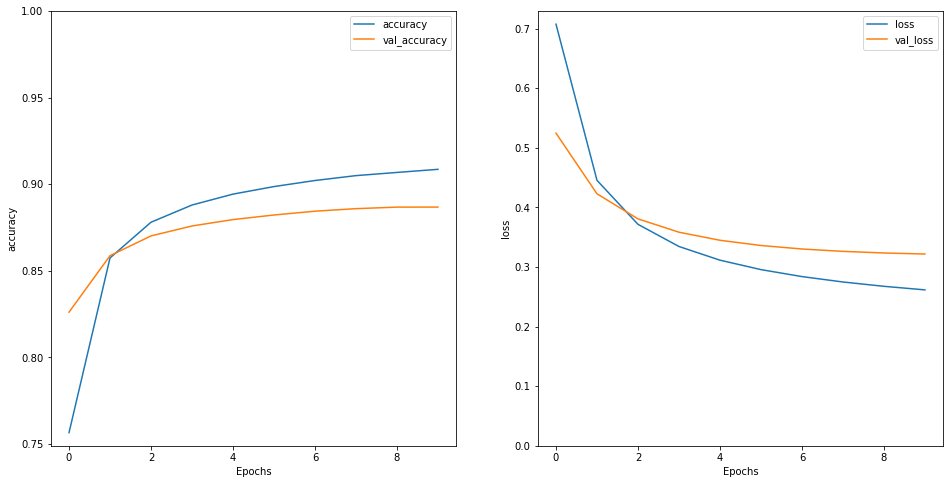

In [ ]:
#Plot - ADDED
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
def create_model(vocab_size, num_labels):
  model = tf.keras.Sequential([
      layers.Embedding(vocab_size, 64, mask_zero=True),
      layers.Conv1D(64, 5, padding="valid", activation="relu", strides=2),
      layers.GlobalMaxPooling1D(),
      layers.Dense(num_labels)
  ])
  return model

In [ ]:
# vocab_size is VOCAB_SIZE + 1 since 0 is used additionally for padding.
int_model = create_model(vocab_size=VOCAB_SIZE + 1, num_labels=4)
int_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])
history = int_model.fit(int_train_ds, validation_data=int_val_ds, epochs=5)

Epoch 1/5
4540/4540 [==============================] - 1137s 250ms/step - loss: 0.5456 - accuracy: 0.7937 - val_loss: 0.2951 - val_accuracy: 0.8952
Epoch 2/5
4540/4540 [==============================] - 81s 18ms/step - loss: 0.2389 - accuracy: 0.9158 - val_loss: 0.2869 - val_accuracy: 0.8999
Epoch 3/5
4540/4540 [==============================] - 84s 18ms/step - loss: 0.1765 - accuracy: 0.9388 - val_loss: 0.3039 - val_accuracy: 0.9005
Epoch 4/5
4540/4540 [==============================] - 82s 18ms/step - loss: 0.1357 - accuracy: 0.9539 - val_loss: 0.3368 - val_accuracy: 0.8979
Epoch 5/5
4540/4540 [==============================] - 82s 18ms/step - loss: 0.1076 - accuracy: 0.9643 - val_loss: 0.3793 - val_accuracy: 0.8972


(0.0, 0.40236879922449587)

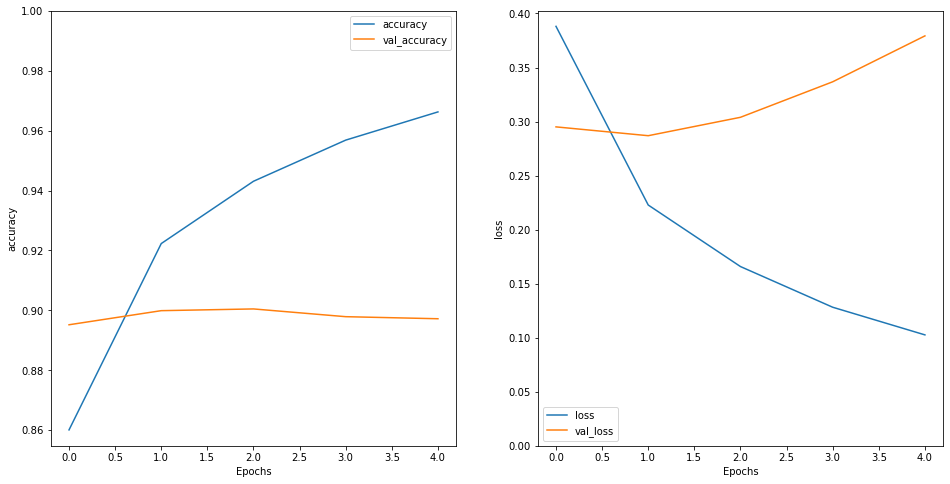

In [ ]:
#Plot - ADDED
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [ ]:
print("Linear model on binary vectorized data:")
print(binary_model.summary())

Linear model on binary vectorized data:
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 40004     
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
print("ConvNet model on int vectorized data:")
print(int_model.summary())

ConvNet model on int vectorized data:
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640064    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          20544     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 660,868
Trainable params: 660,868
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#we compare the results of both models
binary_loss, binary_accuracy = binary_model.evaluate(binary_val_ds)
int_loss, int_accuracy = int_model.evaluate(int_val_ds)

print("Binary model accuracy: {:2.2%}".format(binary_accuracy))
print("Int model accuracy: {:2.2%}".format(int_accuracy))

1135/1135 [==============================] - 4s 4ms/step - loss: 0.3793 - accuracy: 0.8972
Binary model accuracy: 88.68%
Int model accuracy: 89.72%
